29.11.2020

### Image Processing in Physics

#### Julia Herzen, Klaus Achterhold, Clemens Schmid, Manuel Schultheiss

# Exercise 04 -- B: Temperature analysis 

In this exercise, we will look at the development of monthly temperature in Germany from 1881 to 2019.

This is another small reference to the [Public Climate School](https://studentsforfuture.info/public-climate-school/).

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import datetime

%matplotlib inline

First, we will load in the data. The temperature per month per federal state ("Bundesland") and German mean are stored in `.csv` files. "csv" stands for "comma-separated values" and denotes a common way to store tabular data. 

We have one file per month, each file containing all years. To get all months in all years, we iterate over all files and construct an array from there. 

A prevalent and powerful library for loading and processing tabular data is [pandas](https://pandas.pydata.org/). For simplicity, we only use `numpy.loadtxt` here and construct the data ourselves. If you want to handle bigger/more complex datastructures, you should consider using pandas.

## Load and analyze

Define the path to the files with a placeholder for the month. Have a look at the .csv files and how the month is encoded: 
- You need a placeholder for an **integer**: Use `%i` (old style) or `{:d}` (new style)
- It should be **zero-padded** to length 2: We use `%02i` or `{:02d}` for that.

In [11]:
fname = "temp/regional_averages_tm_{:02d}.csv"

In [12]:
!tree temp

temp
├── regional_averages_tm_01.csv
├── regional_averages_tm_02.csv
├── regional_averages_tm_03.csv
├── regional_averages_tm_04.csv
├── regional_averages_tm_05.csv
├── regional_averages_tm_06.csv
├── regional_averages_tm_07.csv
├── regional_averages_tm_08.csv
├── regional_averages_tm_09.csv
├── regional_averages_tm_10.csv
├── regional_averages_tm_11.csv
└── regional_averages_tm_12.csv

0 directories, 12 files


Iterate over all files. 
1. Use the index to complete the filename template from above
2. Use the function `np.loadtxt` to load the data as an array. You have to specify the correct delimiter. (Look at the docstring what that means)
3. Discard the first two columns, as they only contain the year and the month index.
4. Append the remaining data to the list

In [13]:
temp_lst = []
for i in range(1, 13):
    print(fname.format(i))
    data = np.loadtxt(fname.format(i), delimiter=";")
    temp_month = data[:, 2:]
    temp_lst.append(temp_month)

temp/regional_averages_tm_01.csv
temp/regional_averages_tm_02.csv
temp/regional_averages_tm_03.csv
temp/regional_averages_tm_04.csv
temp/regional_averages_tm_05.csv
temp/regional_averages_tm_06.csv
temp/regional_averages_tm_07.csv
temp/regional_averages_tm_08.csv
temp/regional_averages_tm_09.csv
temp/regional_averages_tm_10.csv
temp/regional_averages_tm_11.csv
temp/regional_averages_tm_12.csv


Convert the list to an array and check the shape. The axes are (month, year, state). The last "state" is the averaged temperature.

In [14]:
temp_arr = np.array(temp_lst)

assert temp_arr.shape == (12, 139, 17)

Transpose the data such that states are on the 0-th axis, and combine months and years into one axis. We will use only the mean data for overall Germany, which is the last "state" in our array.

In [15]:
# Transpose and combine -> (17, 1668)
temp_flat = temp_arr.transpose(2, 1, 0).reshape(17, -1)
print(temp_flat.shape)

# Use only Germany
temp_ger = temp_flat[-1]

(17, 1668)


Define the x-axis for plotting all data points. We define the years and the months and combine them to get a long list of `datetime` objects, which pyplot can handle.

In [16]:
years = np.arange(1881, 2020)
months = np.arange(1, 13)
dates = [datetime.date(year, month, 1)   # `1` is a placeholder for day
         for year in years     # outer loop
         for month in months]  # inner loop
dates[:5]

[datetime.date(1881, 1, 1),
 datetime.date(1881, 2, 1),
 datetime.date(1881, 3, 1),
 datetime.date(1881, 4, 1),
 datetime.date(1881, 5, 1)]

Plot the temperature data for Germany. It is dominated by an oscillation, while the slow rise in temperature is barely visible.

Text(0.5, 1.0, 'Temperature per month')

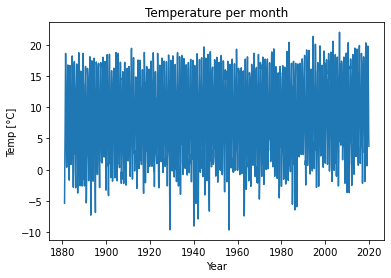

In [17]:
plt.figure()
plt.plot(dates, temp_ger)
plt.xlabel("Year")
plt.ylabel("Temp [°C]")
plt.title("Temperature per month")

That oscillation is caused by seasonal temperature changes. It's cold in the winter and warm in the summer, even with global warming! 

Have a look at the seasonal difference by plotting all years over each other. You have to use the unflattened `temp_arr` and plot each year over the same months. 

Hint: If you give pyplot an array with shape $(m, n)$ for the y-axis, it plots $n$ graphs over $m$ datapoints. We want $\#years$ graphs over $\#months$ datapoints. The `temp_arr` array alreay has the correct shape, just select only the overall german temperature! (last element of 2nd axis)

Text(0.5, 1.0, 'Monthly temperature over all years')

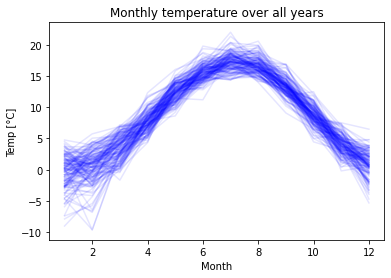

In [18]:
plt.figure()
plt.plot(months, temp_arr[..., -1], c="b", alpha=0.1)
plt.xlabel("Month")
plt.ylabel("Temp [°C]")
plt.title("Monthly temperature over all years")

We can look at the Fourier transform of the temperature to identify the seasonal fluctuation. 

To plot the spectrum sensibly, we need the correct frequency values. What is the sampling distance `d` of our datapoints if we think in units of years? 

Hint: We want the seasonal oscillation to have frequency 1.

Text(0, 0.5, '|F(u)|')

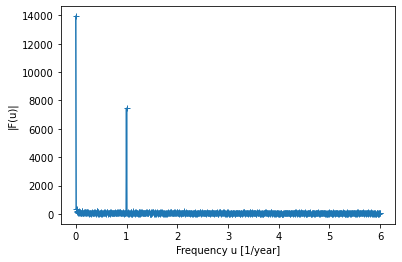

In [19]:
temp_ger_ft = np.fft.rfft(temp_ger)
freq = np.fft.rfftfreq(temp_ger.shape[0], d=1/12)

plt.figure()
plt.plot(freq, np.abs(temp_ger_ft), '+-')
plt.xlabel("Frequency u [1/year]")
plt.ylabel("|F(u)|")

## Filtering

We want to remove the oscillation from our data, so that we can identify the slow rise in temperature over the decades. 

First, we apply a Gaussian low-pass filter in Fourier domain. Choose $\sigma$ such that the strong oscillation at $u = 1$ is suppressed. As coordinates, use `freq`.

In [20]:
sigma = 0.1
w_lowpass = np.exp(-freq**2 / (2*sigma**2))
temp_ger_lowpass_ft = temp_ger_ft * w_lowpass
temp_ger_lowpass = np.fft.irfft(temp_ger_lowpass_ft).real

If we want to preserve other high-frequency features and only want to suppress the seasonal change, we instead apply a bandstop filter to the frequency we want to suppress specifically. 

A very crude bandstop filter blocks one frequency completely and lets all others through. You have to select the index where our coordinates `freq` are 1.

In [21]:
w_bandstop = np.ones_like(freq)
w_bandstop[np.isclose(freq, 1)] = 0
temp_ger_bandstop_ft = temp_ger_ft * w_bandstop
temp_ger_bandstop = np.fft.irfft(temp_ger_bandstop_ft).real

Now we look at the filtered data. The "bandstopped" signal still shows fluctuations, which may or may not be desirable depending on the context. The lowpass-filtered signal is very smooth, but contains less information. 

The rise in temperature is visible nevertheless.

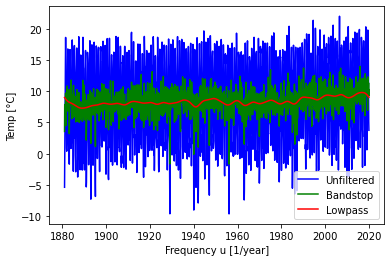

In [22]:
plt.figure()
plt.plot(dates, temp_ger, "b", label="Unfiltered")
plt.plot(dates, temp_ger_bandstop, "g", label="Bandstop")
plt.plot(dates, temp_ger_lowpass, "r", label="Lowpass")
plt.xlabel("Frequency u [1/year]")
plt.ylabel("Temp [°C]")
plt.legend()

Finally, we want to look at the power spectrum of the signal and how it changes from the filters. 

Compute the power spectra. The power spectrum $S(w)$ of a signal $f(x)$ is $S(w) = | F (w) |^2$.

In [23]:
ps_unfiltered = np.abs(temp_ger_ft)**2
ps_lowpass = np.abs(temp_ger_lowpass_ft)**2
ps_bandstop = np.abs(temp_ger_bandstop_ft)**2

Now we plot the spectra. The unfiltered data shows the large peak at 1, which is suppressed in the bandstopped signal to 0. The lowpass-filtered signal still shows the peak, but it's attenuated together with the other higher frequencies.

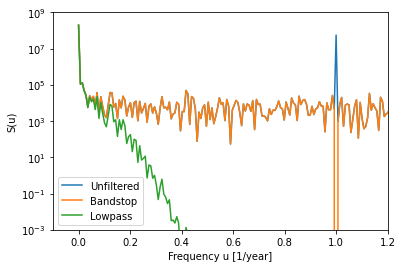

In [24]:
plt.figure()
plt.semilogy(freq, ps_unfiltered, label="Unfiltered")
plt.semilogy(freq, ps_bandstop, label="Bandstop")
plt.semilogy(freq, ps_lowpass, label="Lowpass")
plt.xlabel("Frequency u [1/year]")
plt.ylabel("S(u)")
plt.xlim(-0.1, 1.2); plt.ylim(1e-3, 1e9)
plt.legend()

## Conclusion

We have removed the seasonal variation from the temperature data and visualized a rise in temperature. For the reasons behind this and what you, as scientists, can do, visit [Public Climate School](https://studentsforfuture.info/public-climate-school/).